<img src="http://i68.tinypic.com/iwum1i.png" width="500">

My API key is P5QB6NHSG9CPFQF1

There are 4 steps in the first stage of this project:
    
    1. Data source and form
    2. Data distribution, transformation, normalization and splitting
    3. Price model
    4. Prediction Interval model
    5. Plot result and evaluate models. 
    
Later to-do list:
    1. Data-related
    - add tickers of listed stocks based on Form S-1 in SEC.
    - add delisted stocks based on Form 25 in SEC.
    - real-time update the list instead of preload 
    - source data from YahooFinance, IEX, Tiingo, RapidAPI, Alpaca, Tradier, StockFluence, StockTwits for longer range.
    - delisted or recent listed stocks will be kept and have their missing values handled.

## Data source and form

List of US stocks on Nasdaq, NYSE, NYSE ARCA, NYSE MKT, AMEX, OTC, OTCBB, etc. is predownloaded. 13737 stocks in total.

In [10]:
import csv 

with open('ticker.csv') as csvfile:
    readCSV = csv.reader(csvfile, delimiter=',')
    ticker = []
    company = []
    for row in readCSV:
        t = row[0]
        c = row[1]

        ticker.append(t)
        company.append(c)
print(len(ticker), "stocks in total")

13737 stocks in total


Now let us request each stock through AlphaVanatage API. 

I only have listed stocks, any stock delisted before May 31, 2019 will not be included. Note that stocks not registered with IEX are not included either since AlphaVantage only source from IEX. 

In [13]:
from alpha_vantage.timeseries import TimeSeries
from alpha_vantage.techindicators import TechIndicators
from alpha_vantage.sectorperformance import SectorPerformances
from alpha_vantage.cryptocurrencies import CryptoCurrencies
from alpha_vantage.foreignexchange import ForeignExchange
from pprint import pprint
import matplotlib.pyplot as plt
import numpy as np

In [41]:
def PlotPriceVolume(price_seq, meta_data, display_interval = 100):
    title = meta_data['2. Symbol'] + ", " + meta_data['1. Information']
    fig, ax = plt.subplots(nrows=2)
    price_seq['1. open'].plot(ax=ax[0], figsize=(40, 16), fontsize=25, title = title)
    price_seq['5. volume'].plot(kind='bar', ax=ax[1], figsize=(40, 16), fontsize=25)
    ax[0].title.set_size(30)
    ax[0].set_ylabel('price(USD)', fontsize=30)
    ax[1].set_ylabel('volume(shares)', fontsize=30)
    ax[1].set_xlabel('time', fontsize=30)
    locs, labels = plt.xticks()
    time_point = list(price_seq.index)
    plt.xticks(locs[::display_interval],time_point[::display_interval])
    fig.autofmt_xdate()
    plt.show()

    
def BollingerBands(price_seq, meta_data):
    symbol = meta_data['2. Symbol']
    interval = meta_data['4. Interval']
    ti = TechIndicators(key='P5QB6NHSG9CPFQF1', output_format='pandas')
    BB, meta_data = ti.get_bbands(symbol=symbol, interval=interval, time_period=60)
    title = "Bollingerbands for "+ symbol + ", " + interval
    BB.plot(figsize=(40, 16), fontsize=25)
    plt.title(title, fontsize=30)
    plt.xlabel('time', fontsize=30)
    plt.ylabel('price(USD)', fontsize=30)
    plt.show()
    
def GetStockData(symbol, interval, key='P5QB6NHSG9CPFQF1', peep=1, plot=1, BB=1):
    ts = TimeSeries(key=key, output_format='pandas')
    if interval == "monthly": 
        price_seq, meta_data = ts.get_monthly(symbol=symbol)
    elif interval == "weekly": 
        price_seq, meta_data = ts.get_weekly(symbol=symbol)
    elif interval == "daily":
        price_seq, meta_data = ts.get_daily(symbol=symbol, outputsize='full')
    elif interval == "60min" or "5min" or "1min":
        price_seq, meta_data = ts.get_intraday(symbol=symbol,interval=interval, outputsize='full')
    else: print("options for interval are: montly, weekly, daily, 5min, 1min")
    if peep == 1:
        print("Data sequence length:", len(price_seq), '\n')
        print("Meta data: ", meta_data, '\n')
        print("Begining market:", '\n', price_seq.head(3), '\n')
        print("Current market:", '\n', price_seq.tail(3), '\n')
    if plot == 1:
        PlotPriceVolume(price_seq = price_seq, meta_data = meta_data)
    if BB == 1:
        BollingerBands(price_seq, meta_data)
    return price_seq, meta_data

I will call a single stock just to have a look of the price and volume as you usually can see in trading stations. 

I use AK steal as an example here. It's the pennby stock Robinhood gave me for free. 

Let's have a look at the raw data and its meta data first:

Data sequence length: 1923 

Meta data:  {'1. Information': 'Intraday (1min) open, high, low, close prices and volume', '2. Symbol': 'AKS', '3. Last Refreshed': '2019-05-31 16:00:00', '4. Interval': '1min', '5. Output Size': 'Full size', '6. Time Zone': 'US/Eastern'} 

Begining market: 
                      1. open  2. high  3. low  4. close  5. volume
date                                                              
2019-05-24 09:31:00   2.1500   2.1800  2.1457    2.1799   184054.0
2019-05-24 09:32:00   2.1701   2.1701  2.1600    2.1650    43082.0
2019-05-24 09:33:00   2.1600   2.1700  2.1400    2.1400    56377.0 

Current market: 
                      1. open  2. high  3. low  4. close  5. volume
date                                                              
2019-05-31 15:58:00   1.7300     1.73  1.7200    1.7299    59420.0
2019-05-31 15:59:00   1.7202     1.73  1.7200    1.7300    72399.0
2019-05-31 16:00:00   1.7300     1.73  1.7223    1.7300   101160.0 



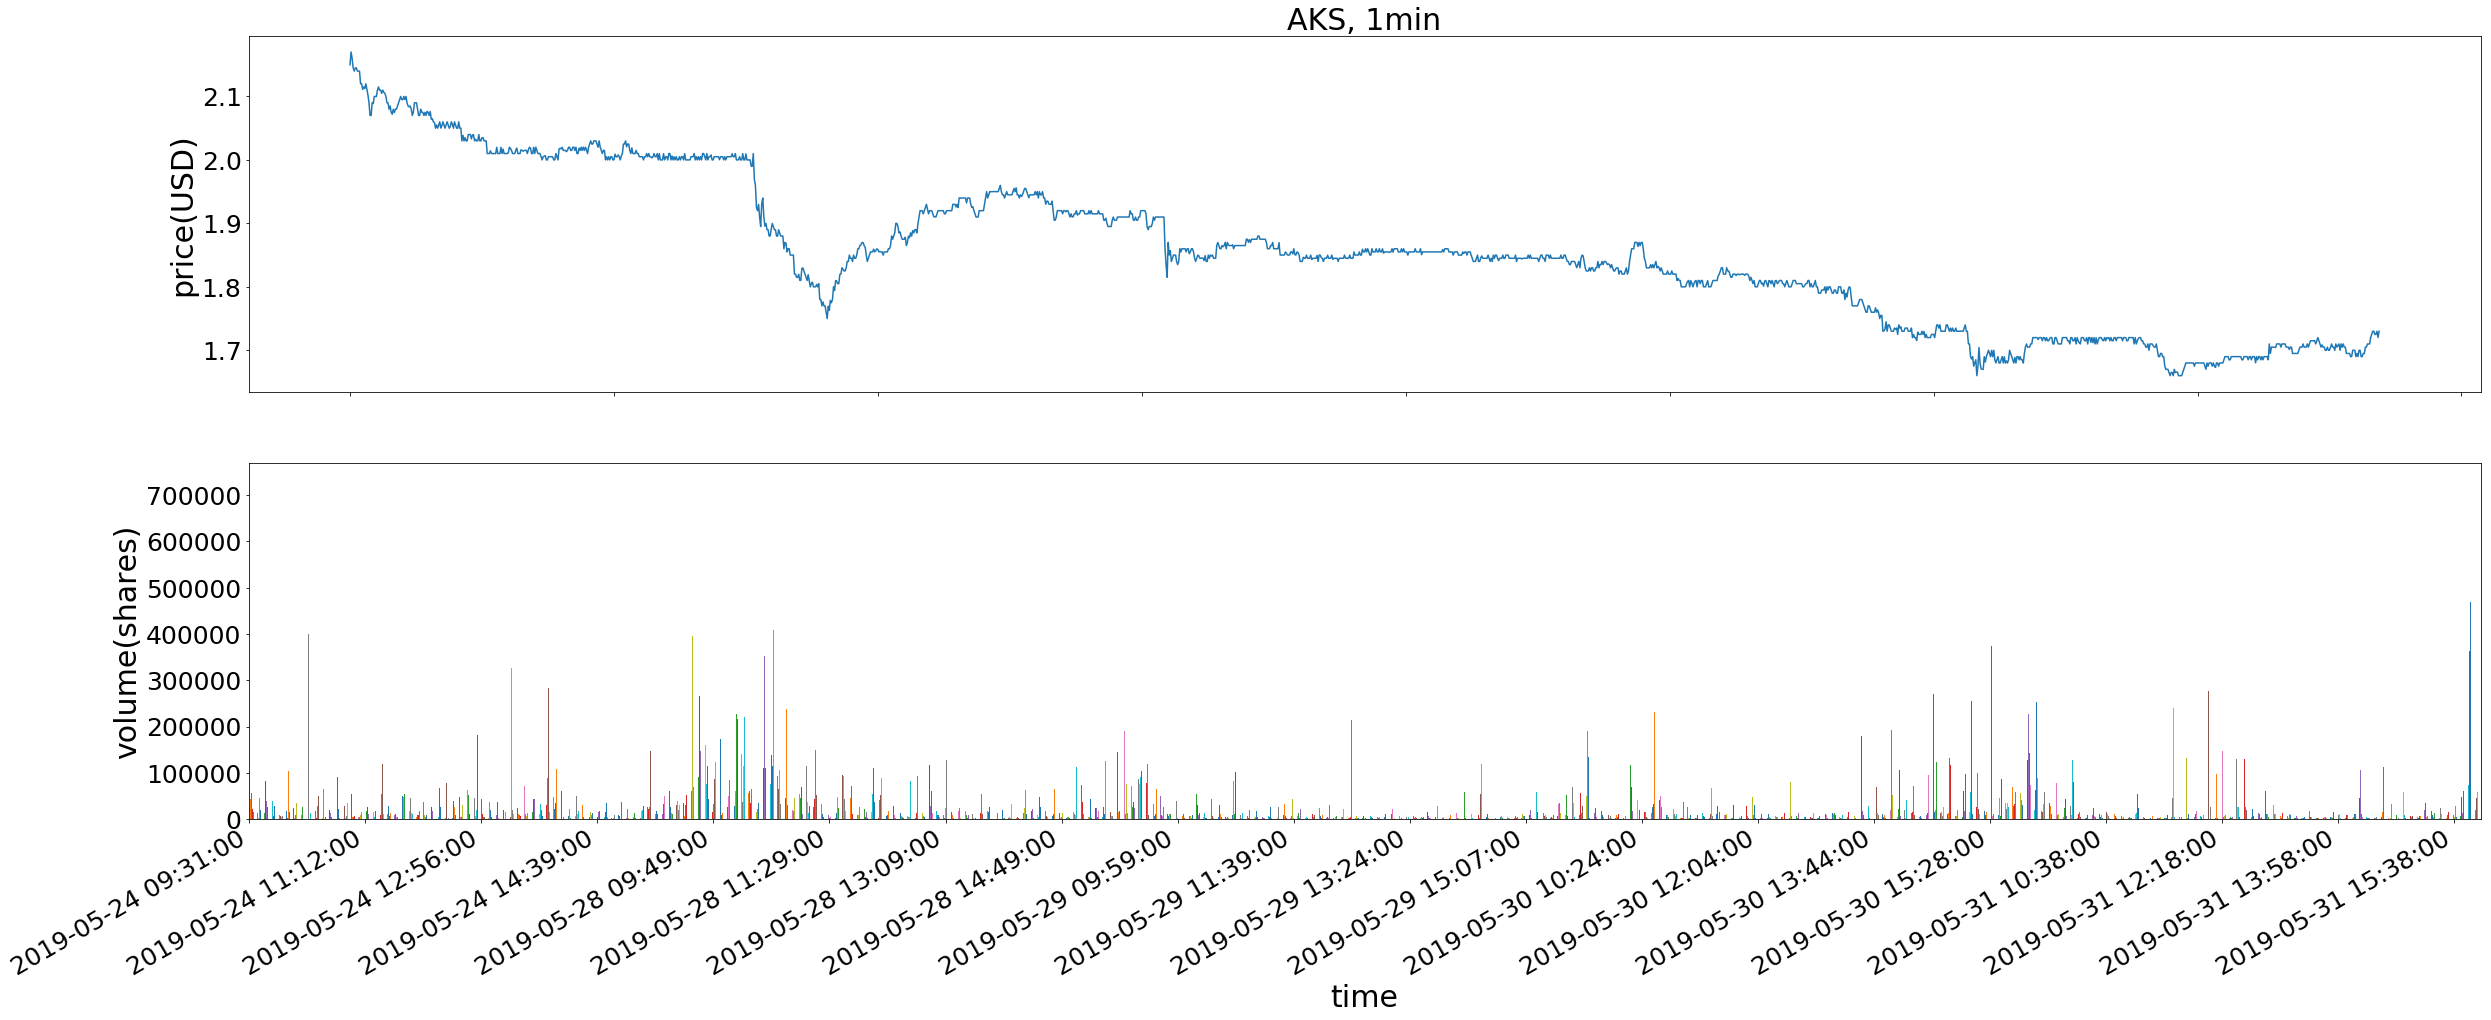

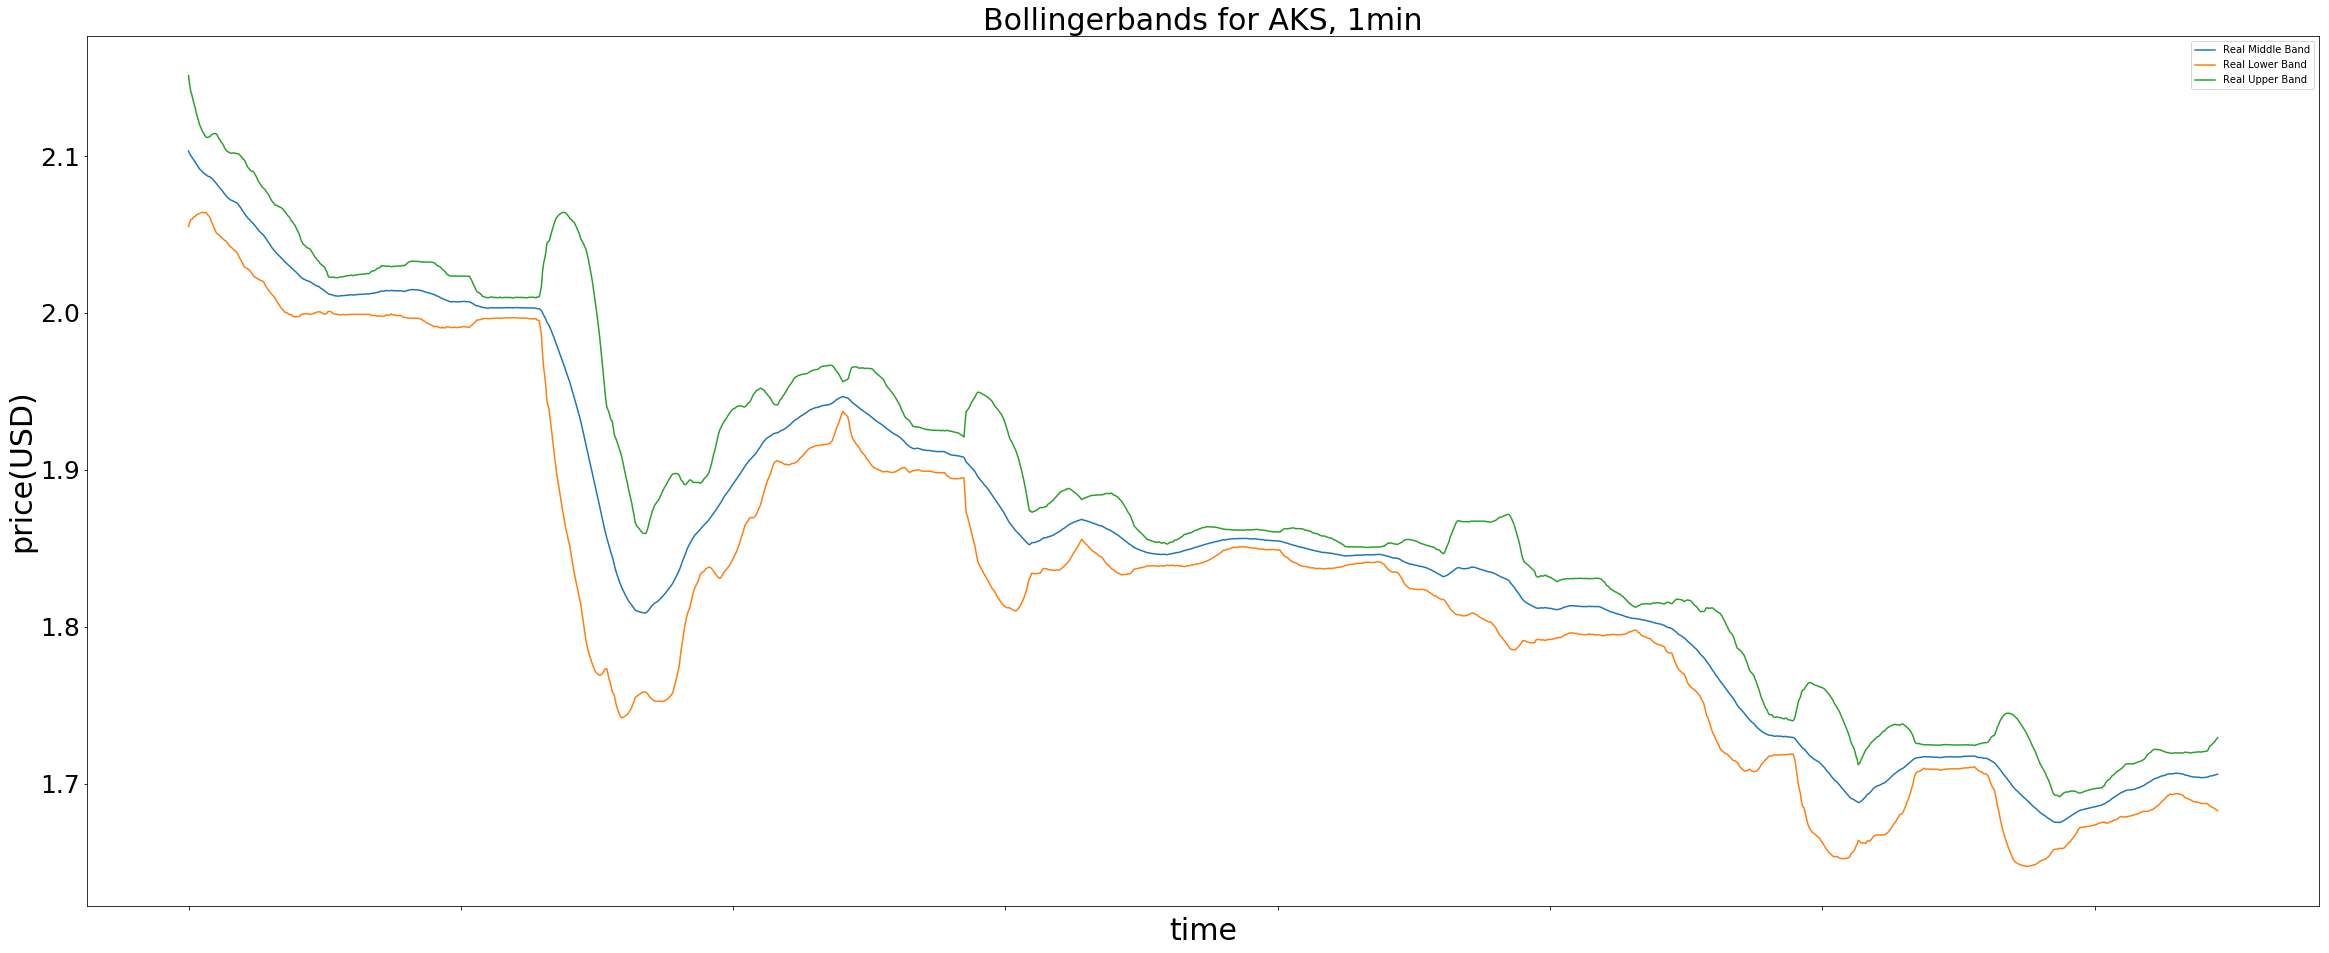

In [21]:
price_seq, meta_data = GetStockData(symbol='AKS',interval='1min', peep=1, plot=1, BB=1)

Now we can request data in batch based on the ticker list. AlphaVantage provides six options for time interval. The data will have dimension:

`stocks_num * time_interval * time_steps * features `

stocks_num: number of stocks data we successfully obtained.
time_interval: monthly, weekly, daily, 60min, 5min, 1min. 
time_steps: 1.7k usually, varies based on time_interval.

In [36]:
price_seq, meta_data = GetStockData(symbol='AKS',interval='monthly', peep=1, plot=0, BB=0)

Data sequence length: 257 

Meta data:  {'1. Information': 'Monthly Prices (open, high, low, close) and Volumes', '2. Symbol': 'AKS', '3. Last Refreshed': '2019-06-03 09:43:42', '4. Time Zone': 'US/Eastern'} 

Begining market: 
             1. open  2. high  3. low  4. close  5. volume
date                                                     
1998-02-27    18.00    18.75   17.69     18.69  4746100.0
1998-03-31    18.75    21.62   18.38     21.12  6163300.0
1998-04-30    21.06    22.19   19.00     21.00  3724000.0 

Current market: 
             1. open  2. high  3. low  4. close    5. volume
date                                                       
2019-04-30     2.79     2.96    2.35      2.42  155044795.0
2019-05-31     2.40     2.61    1.66      1.72  176988320.0
2019-06-03     1.71     1.78    1.73      1.77     731128.0 



In [49]:
print("monthly---------------------------------------------------------------------------")
price_seq, meta_data = GetStockData(symbol='AKS',interval='monthly', peep=1, plot=0, BB=0) #257
print("weekly---------------------------------------------------------------------------")
price_seq, meta_data = GetStockData(symbol='AKS',interval='weekly', peep=1, plot=0, BB=0) #1118
print("daily---------------------------------------------------------------------------")
price_seq, meta_data = GetStockData(symbol='AKS',interval='daily', peep=1, plot=0, BB=0) #5388
print("60min---------------------------------------------------------------------------")
price_seq, meta_data = GetStockData(symbol='AKS',interval='60min', peep=1, plot=0, BB=0) #415
print("5min---------------------------------------------------------------------------")
price_seq, meta_data = GetStockData(symbol='AKS',interval='5min', peep=1, plot=0, BB=0) #1097
print("1min---------------------------------------------------------------------------")
#price_seq, meta_data = GetStockData(symbol='AKS',interval='1min', peep=0, plot=0, BB=0) #1563

monthly---------------------------------------------------------------------------
Data sequence length: 257 

Meta data:  {'1. Information': 'Monthly Prices (open, high, low, close) and Volumes', '2. Symbol': 'AKS', '3. Last Refreshed': '2019-06-03 09:55:22', '4. Time Zone': 'US/Eastern'} 

Begining market: 
             1. open  2. high  3. low  4. close  5. volume
date                                                     
1998-02-27    18.00    18.75   17.69     18.69  4746100.0
1998-03-31    18.75    21.62   18.38     21.12  6163300.0
1998-04-30    21.06    22.19   19.00     21.00  3724000.0 

Current market: 
             1. open  2. high  3. low  4. close    5. volume
date                                                       
2019-04-30     2.79     2.96    2.35      2.42  155044795.0
2019-05-31     2.40     2.61    1.66      1.72  176988320.0
2019-06-03     1.73     1.80    1.73      1.79    1091728.0 

weekly----------------------------------------------------------------------

Now let's start machine learning: ୧⍢⃝୨

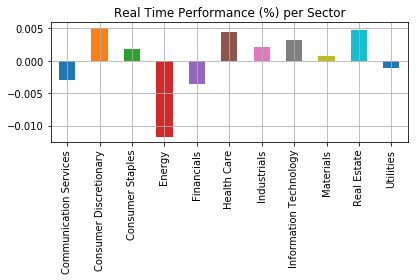

In [145]:
def Sector():
    sp = SectorPerformances(key='P5QB6NHSG9CPFQF1', output_format='pandas')
    data, meta_data = sp.get_sector()
    data['Rank A: Real-Time Performance'].plot(kind='bar')
    plt.title('Real Time Performance (%) per Sector')
    plt.tight_layout()
    plt.grid()
    plt.show()
Sector()

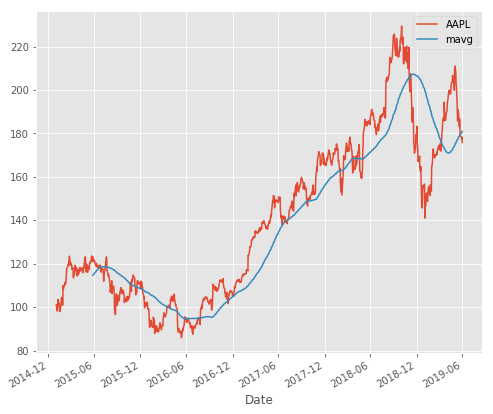

In [16]:
import pandas as pd
import datetime
import pandas_datareader.data as web
from pandas import Series, DataFrame
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib as mpl

start = datetime.datetime(2015, 1, 1)
end = datetime.datetime(2019, 5, 31)

df = web.DataReader("AAPL", 'yahoo', start, end)
df.tail()

close_px = df['Adj Close']
mavg = close_px.rolling(window=100).mean()


mpl.rc('figure', figsize=(8, 7))
mpl.__version__

# Adjusting the style of matplotlib
style.use('ggplot')

close_px.plot(label='AAPL')
mavg.plot(label='mavg')
plt.legend()

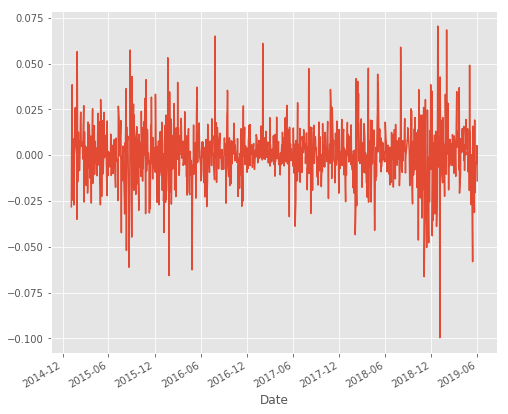

In [17]:
rets = close_px / close_px.shift(1) - 1
rets.plot(label='return')

In [22]:
dfcomp = web.DataReader(['AAPL', 'GE', 'GOOG', 'IBM', 'MSFT'],'yahoo',start=start,end=end)['Adj Close']
dfcomp.tail()

Symbols,AAPL,GE,GOOG,IBM,MSFT
Date,,,,,
2019-05-24,178.970001,9.450,1133.469971,132.279999,126.239998
2019-05-28,178.229996,9.360,1134.150024,130.460007,126.160004
2019-05-29,177.380005,9.370,1116.459961,129.690002,124.940002
2019-05-30,178.300003,9.470,1117.949951,129.570007,125.730003
2019-05-31,175.330002,9.385,1104.390015,127.099998,123.675003


In [23]:
retscomp = dfcomp.pct_change()

corr = retscomp.corr()
corr

Symbols,AAPL,GE,GOOG,IBM,MSFT
Symbols,,,,,
AAPL,1.000000,0.257163,0.520277,0.386761,0.570081
GE,0.257163,1.000000,0.253388,0.361761,0.268957
GOOG,0.520277,0.253388,1.000000,0.407256,0.661508
IBM,0.386761,0.361761,0.407256,1.000000,0.478723
MSFT,0.570081,0.268957,0.661508,0.478723,1.000000


Text(0,0.5,'Returns GE')

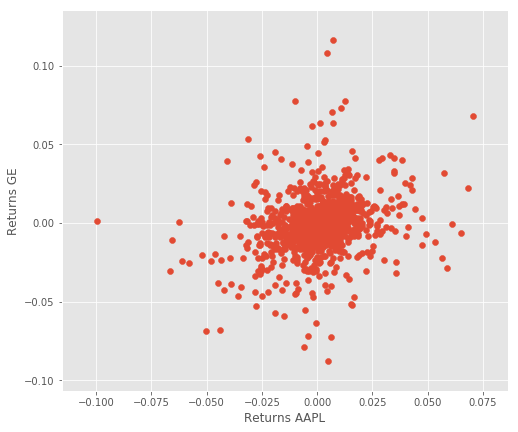

In [25]:
plt.scatter(retscomp.AAPL, retscomp.GE)
plt.xlabel('Returns AAPL')
plt.ylabel('Returns GE')

/home/ec2-user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: pandas.scatter_matrix is deprecated. Use pandas.plotting.scatter_matrix instead
  """Entry point for launching an IPython kernel.


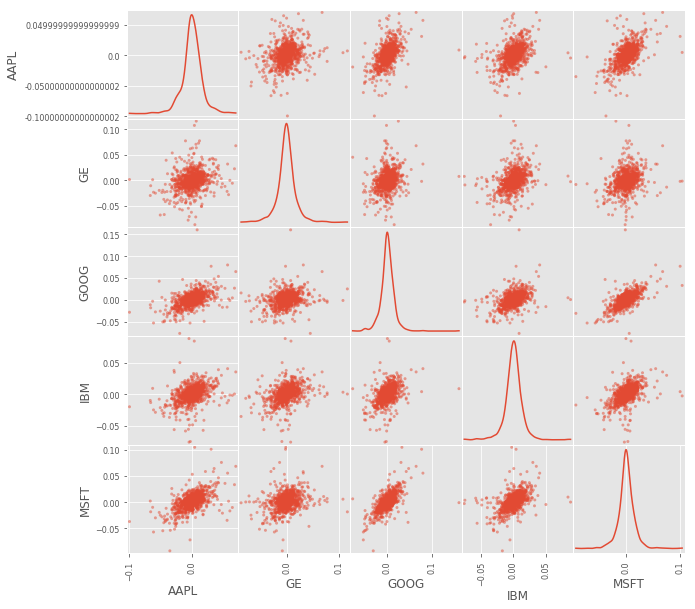

In [26]:
pd.scatter_matrix(retscomp, diagonal='kde', figsize=(10, 10));

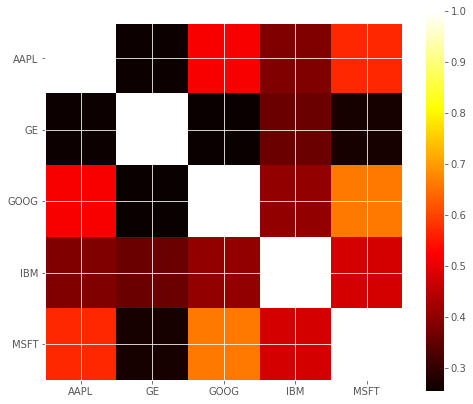

In [27]:
plt.imshow(corr, cmap='hot', interpolation='none')
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns)
plt.yticks(range(len(corr)), corr.columns);

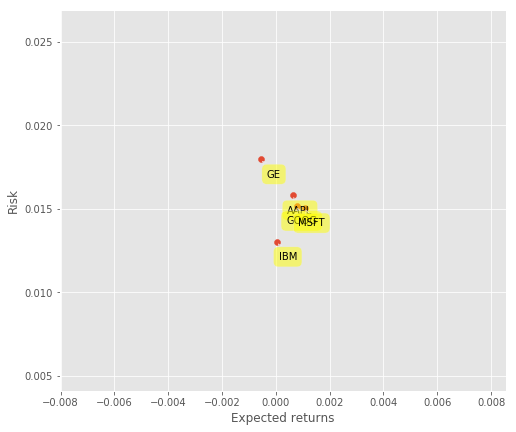

In [29]:
plt.scatter(retscomp.mean(), retscomp.std())
plt.xlabel('Expected returns')
plt.ylabel('Risk')
for label, x, y in zip(retscomp.columns, retscomp.mean(), retscomp.std()):
    plt.annotate(
        label, 
        xy = (x, y), xytext = (20, -20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

In [32]:
dfreg = df.loc[:,['Adj Close','Volume']]
dfreg['HL_PCT'] = (df['High'] - df['Low']) / df['Close'] * 100.0
dfreg['PCT_change'] = (df['Close'] - df['Open']) / df['Open'] * 100.0

In [40]:
import math
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
# Drop missing value
dfreg.fillna(value=-99999, inplace=True)
# We want to separate 1 percent of the data to forecast
forecast_out = int(math.ceil(0.01 * len(dfreg)))
# Separating the label here, we want to predict the AdjClose
forecast_col = 'Adj Close'
dfreg['label'] = dfreg[forecast_col].shift(-forecast_out)
X = np.array(dfreg.drop(['label'], 1))
# Scale the X so that everyone can have the same distribution for linear regression
X = preprocessing.scale(X)
# Finally We want to find Data Series of late X and early X (train) for model generation and evaluation
X_lately = X[-forecast_out:]
X = X[:-forecast_out]
# Separate label and identify it as y
y = np.array(dfreg['label'])
y = y[:-forecast_out]